In [30]:
# Import Dependencies
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

In [31]:
# Settings
targetList = targets
featureSetsFile = "all_targets_mfcc_sets.npz"
sampleToWorkOn  = 0.1
validationSize  = 0.1
testSize        = 0.1
sampleRate      = 8000
numMFCC         = 16
lenMFCC         = 16   # Length of max MFCC, following the duration of WAV length in seconds

In [32]:
dataset_path = "../../Dataset/speech_data"
for index, name in enumerate(tqdm(listdir(dataset_path))):
    pass

100%|██████████| 37/37 [00:00<00:00, 95855.00it/s]


In [33]:
# Create an all target list
targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]

# Truncated Background Noise
targets.remove("_background_noise_")

# Check sample for each dataset
totalSample = 0
for target in targets:
    sample = len(listdir(join(dataset_path, target)))
    totalSample += sample
    
print("Total sample : {}".format(totalSample))

Total sample : 105831


In [24]:
# Create list of filenames with ground truth of y
# Examples for filenames c1d39ce8_nohash_1.wav is in folder dog
# DOG is in index 0
# so the file name c1d39ce8_nohash_1.wav is identified by dog with label 0
filenames = []
y = []

for index, target in enumerate(targetList):
    filenames.append(listdir(join(dataset_path, target)))
    sampleNum = len(filenames[index])
    y.append(np.ones(sampleNum) * index)

In [25]:
# Check ground truth y vector
print(y)
sampleTotal = 0
for item in y:
    sampleNum   = len(item)
    sampleTotal += sampleNum
    print(sampleNum)
print("Total : {}".format(sampleTotal))

[array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.]), array([2., 2.]), array([3., 3., 3., ..., 3., 3., 3.]), array([4., 4., 4., ..., 4., 4., 4.]), array([5., 5., 5., ..., 5., 5., 5.]), array([6., 6., 6., ..., 6., 6., 6.]), array([7., 7., 7., ..., 7., 7., 7.]), array([8., 8., 8., ..., 8., 8., 8.]), array([9., 9., 9., ..., 9., 9., 9.]), array([10., 10., 10., ..., 10., 10., 10.]), array([11., 11., 11., ..., 11., 11., 11.]), array([12., 12., 12., ..., 12., 12., 12.]), array([13., 13., 13., ..., 13., 13., 13.]), array([14., 14., 14., ..., 14., 14., 14.]), array([15., 15., 15., ..., 15., 15., 15.]), array([16., 16., 16., ..., 16., 16., 16.]), array([17., 17., 17., ..., 17., 17., 17.]), array([18., 18., 18., ..., 18., 18., 18.]), array([19., 19., 19., ..., 19., 19., 19.]), array([20., 20., 20., ..., 20., 20., 20.]), array([21., 21., 21., ..., 21., 21., 21.]), array([22., 22., 22., ..., 22., 22., 22.]), array([23., 23., 23., ..., 23., 23., 23.]), array([24., 24., 24., ..

In [26]:
# Convert the 2d array to 1d array
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [27]:
# Associate filenames with true output and shuffle
filenamesY = list(zip(filenames, y))
random.shuffle(filenamesY)
filenames, y = zip(*filenamesY)

In [28]:
# Only keep the specified number of samples 
print(len(filenames))
filenames = filenames[:int(len(filenames) * sampleToWorkOn)]
print(len(filenames))

105831
10583


In [29]:
# Calculate Validation and Test Set Ratio size
sizeOfValidation = int(len(filenames) * validationSize)
sizeOfTest       = int(len(filenames) * testSize)

# Break the Training, Validation, and Test Dataset
filenamesValidation = filenames[:sizeOfValidation]
filenamesTest       = filenames[sizeOfValidation:(sizeOfValidation + sizeOfTest)]
filenamesTrain      = filenames[(sizeOfValidation + sizeOfTest):]

yValidation = y[:sizeOfValidation]
yTest       = y[sizeOfValidation:(sizeOfValidation + sizeOfTest)]
yTrain      = y[(sizeOfValidation + sizeOfTest):]

In [12]:
# Function : Create MFCC from path
def calcMFCC(path):
    
    # Load Wavefile
    signal, fs = librosa.load(path, sr = sampleRate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal,
                                             samplerate=fs,
                                             winlen=0.256,
                                             winstep=0.050,
                                             numcep=numMFCC,
                                             nfilt = 26,
                                             nfft  = 2048,
                                             preemph=0.0,
                                             ceplifter=0,
                                             appendEnergy=False,
                                             winfunc=np.hanning)
    return mfccs.transpose()

In [13]:
# TEST: Construct test set by computing MFCC of each wave file
propCnt = 0
xTest = []
yTest = []

for index, filename in enumerate(filenamesTrain):
    
    # Break when hit 500
    if index >= 500:
        break
    
    # Create the path from given filename and target item
    path = join(dataset_path, targetList[int(yTrain[index])], filename)
    
    # Create MFCCS
    mfccs = calcMFCC(path)
    
    if mfccs.shape[1] == lenMFCC:
        xTest.append(mfccs)
        yTest.append(yTrain[index])
    else:
        print("Dropped : ", index,mfccs.shape)
        propCnt += 1
    

Dropped :  20 (16, 11)
Dropped :  41 (16, 12)
Dropped :  56 (16, 15)
Dropped :  90 (16, 15)
Dropped :  94 (16, 12)
Dropped :  100 (16, 15)
Dropped :  109 (16, 7)
Dropped :  113 (16, 15)
Dropped :  116 (16, 12)
Dropped :  124 (16, 8)
Dropped :  127 (16, 15)
Dropped :  140 (16, 9)


KeyboardInterrupt: 

In [124]:
print("% of problematic samples : ", propCnt / 500)

% of problematic samples :  0.09


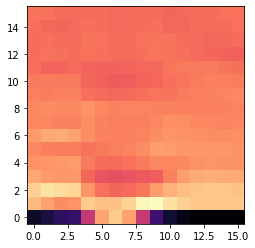

In [31]:
from playsound import playsound

# Get the path for audio wav file
idx = 200
path = "speech_data/Test/1.wav"
    
def extractMFCC(path):
    # Create the mfccs for the path
    mfccs = calcMFCC(path)
    #print('MFCCS : ', mfccs)
    
    # Show the MFCCS data
    fig = plt.figure()
    plt.imshow(mfccs, cmap="magma", origin="lower")
    return mfccs

extractMFCC(path)
playsound(path)

In [25]:
from tqdm import tqdm

def extractFeatures(inFiles, inY):
    probCnt = 0
    outputX = []
    outputY = []
    
    for index, filename in (enumerate(tqdm(inFiles))):

        # Create the path from given filename and target item
        path = join(dataset_path, targetList[int(inY[index])], filename)
    
        # Check to make sure if it's a valid audio file
        if not path.endswith(".wav"):
            continue
        
        # Create MFCCS
        mfccs = calcMFCC(path)

        if mfccs.shape[1] == lenMFCC:
            outputX.append(mfccs)
            outputY.append(inY[index])
            
        else:
            #print("Dropped : ", index,mfccs.shape)
            probCnt += 1
            
    return outputX, outputY, probCnt

In [145]:
# Training
xOutTrain, yOutTrain, prob = extractFeatures(filenamesTrain, yTrain)
print('Removed percentage : ', prob / len(yTrain))

100%|██████████| 8466/8466 [07:36<00:00, 18.56it/s]

Removed percentage :  0.006691543008108916


In [144]:
# Validation
xOutValidation, yOutValidation, prob = extractFeatures(filenamesValidation, yValidation)
print('Removed percentage : ', prob / len(yValidation))

100%|██████████| 1058/1058 [00:49<00:00, 21.34it/s]

Removed percentage :  0.09168241965973535


In [143]:
# Test
xOutTest, yOutTest, prob = extractFeatures(filenamesTest, yTest)
print('Removed percentage : ', prob / len(yTest))

100%|██████████| 1058/1058 [00:48<00:00, 22.04it/s]

Removed percentage :  0.07844990548204159


In [146]:
# Save the feature and truth vector
np.savez(featureSetsFile, 
         x_train=xOutTrain,
         y_train=yOutTrain,
         x_val=xOutValidation,
         y_val=yOutValidation,
         x_test=xOutTest,
         y_test=yOutTest)

In [147]:
featureSets = np.load(featureSetsFile)
featureSets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [148]:
len(featureSets['x_train'])

7772

In [155]:
print(featureSets['x_test'])

[[[-4.17458482e+01 -3.93047294e+01 -2.68786438e+01 ... -5.34477490e+01
   -6.05283479e+01 -6.25279309e+01]
  [-3.37591255e+00 -2.44334102e+00  4.46565998e+00 ...  6.81229307e+00
    6.54379856e+00  6.42874100e+00]
  [ 2.05891756e+00  3.01491090e+00 -3.92676956e-02 ...  1.48047405e+00
   -1.24862627e+00 -1.41935864e+00]
  ...
  [ 2.55342207e-01  1.11847654e-01 -3.20679175e-01 ...  3.53664679e-01
    4.02843914e-01  1.31427502e-01]
  [-5.45864431e-01 -7.43265385e-01 -9.54019518e-01 ... -1.03611589e+00
   -1.07510357e+00 -8.63182949e-01]
  [ 4.04283745e-01  2.95484686e-01  8.00124845e-01 ... -2.58516854e-01
   -6.42663538e-02 -8.24964682e-02]]

 [[-7.66426147e+01 -6.54377562e+01 -5.64850262e+01 ... -5.84199059e+01
   -6.73108905e+01 -7.97140154e+01]
  [ 1.53535530e+01  2.04012387e+01  2.03034697e+01 ...  6.92673429e+00
    8.54790662e+00  9.16755490e+00]
  [ 4.72981162e+00  5.61854780e+00  4.68158180e+00 ...  4.74973857e+00
    3.81453820e+00  2.29765716e+00]
  ...
  [-9.42945609e-01 -7.4

speech_data/Test/1.wav
0.6914374


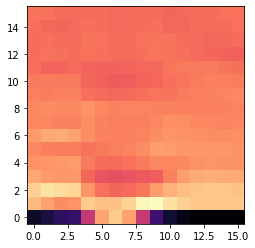

In [36]:
# Checking with not trained data

# Load the model
model_path = "wake_word.model"
model = keras.models.load_model(model_path)

# Get the path for audio wav file
folderName = "Test"
fileName   = "1.wav"
path = join(dataset_path, folderName, fileName)
print(path)

# Put the data to array
xData     = []
mfcc_test = extractMFCC(path)
xData.append(mfcc_test)
finalReshape = xData[0].reshape(xData[0].shape[0],
                                xData[0].shape[1], 1)

predictions = model.predict(np.expand_dims(finalReshape, 0))
predictions = predictions[0][0]
print(predictions)